In [48]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sushanthworks18","key":"cd4728ed897b9b062082e98c9580470e"}'}

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!pip install kaggle

In [51]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [52]:
# !kaggle competitions download <name-of-competition>
!kaggle datasets download adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0


In [6]:
!unzip /content/flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [53]:
!rm -rf /content/flickr8k.zip /content/sample_data

In [54]:
!pip install torch-geometric rouge-score

In [9]:
import os
import re
import time
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch_geometric.nn as gnn
from torch_geometric.data import Data, Batch
import networkx as nx
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import torchvision
from nltk.translate.bleu_score import corpus_bleu
import warnings
warnings.filterwarnings("ignore")
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [55]:
DATASET_PATH = '/content'
IMAGES_PATH = os.path.join(DATASET_PATH, 'Images')
CAPTIONS_FILE = os.path.join(DATASET_PATH, 'captions.txt')

In [56]:
def load_captions(captions_file):
    captions_df = pd.read_csv(captions_file)
    # If the file doesn't have headers, use this instead:
    # captions_df = pd.read_csv(captions_file, header=None, names=['image', 'caption'])

    print(f"Number of captions: {len(captions_df)}")
    print(f"Sample captions:\n{captions_df.head()}")
    return captions_df

captions_df = load_captions(CAPTIONS_FILE)

Number of captions: 40455
Sample captions:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [57]:
captions_df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [58]:
captions_df.shape

(40455, 2)

In [59]:
captions_df = captions_df.head(8000)
# captions_df.shape

In [60]:
def group_captions_by_image(captions_df):
    captions_dict = {}
    for _, row in captions_df.iterrows():
        image_name = row['image']
        caption = row['caption']

        if image_name not in captions_dict:
            captions_dict[image_name] = []
        captions_dict[image_name].append(caption)

    return captions_dict

image_captions = group_captions_by_image(captions_df)
print(f"Number of images: {len(image_captions)}")

Number of images: 1600


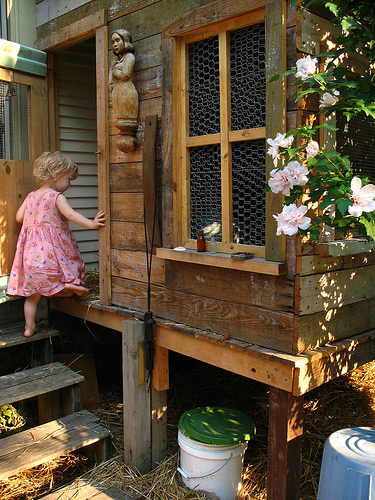

In [61]:
sample_image = list(image_captions.keys())[0]
Image.open(os.path.join(IMAGES_PATH,sample_image))

In [62]:
for i, caption in enumerate(image_captions[sample_image]):
    print(f"Caption {i+1}: {caption}")

Caption 1: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption 2: A girl going into a wooden building .
Caption 3: A little girl climbing into a wooden playhouse .
Caption 4: A little girl climbing the stairs to her playhouse .
Caption 5: A little girl in a pink dress going into a wooden cabin .


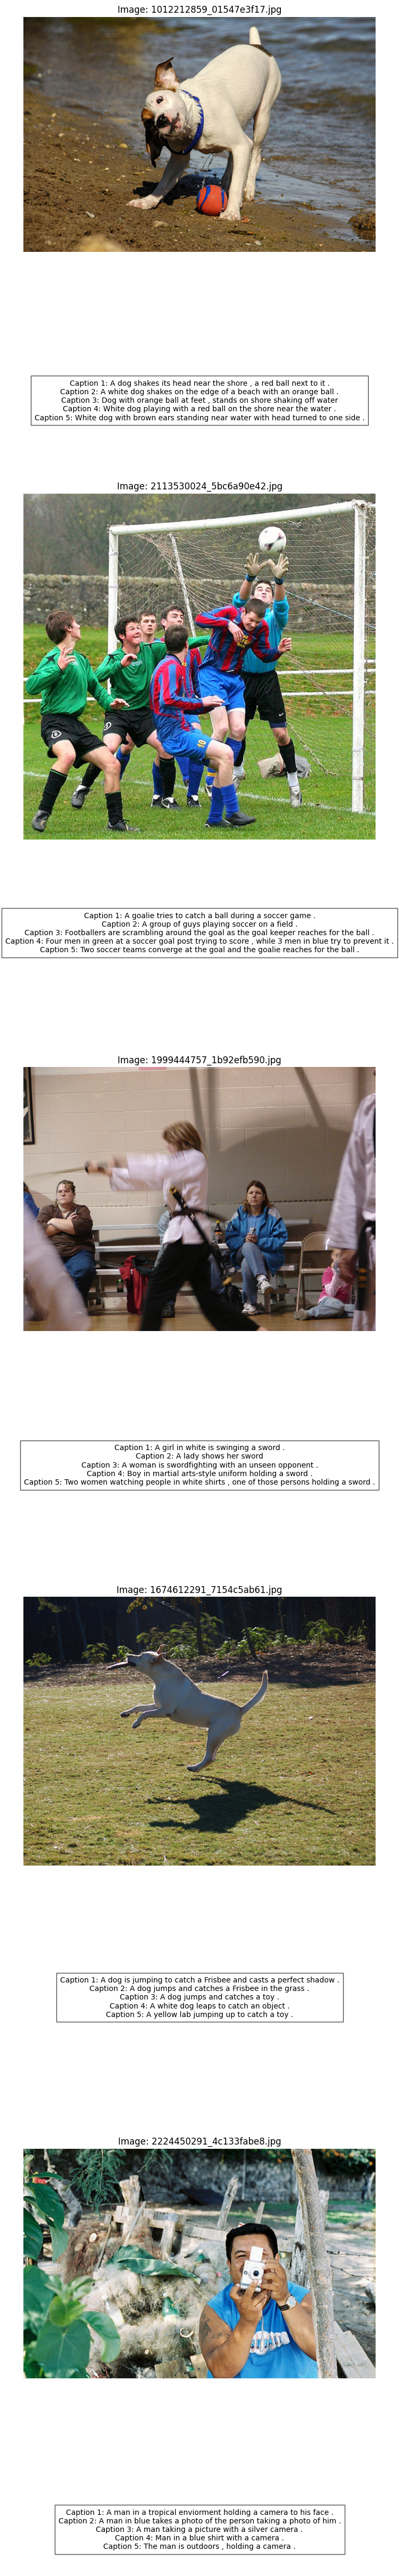

In [63]:
def visualize_samples(images_path, image_captions, num_samples=5):
    image_names = list(image_captions.keys())
    np.random.shuffle(image_names)

    fig, axes = plt.subplots(nrows=min(num_samples, len(image_names)) * 2, ncols=1,
                             figsize=(8, 10 * num_samples), gridspec_kw={'height_ratios': [4, 0.8] * num_samples})

    for i in range(min(num_samples, len(image_names))):
        image_name = image_names[i]
        image_path = os.path.join(images_path, image_name)

        try:
            image = Image.open(image_path)

            # Image display
            axes[2 * i].imshow(image)
            axes[2 * i].set_title(f"Image: {image_name}", fontsize=12)
            axes[2 * i].axis('off')

            # Caption display
            captions = image_captions[image_name]
            caption_text = "\n".join([f"Caption {j+1}: {caption}" for j, caption in enumerate(captions)])
            axes[2 * i + 1].text(0.5, 0.5, caption_text, ha='center', va='center', fontsize=10,
                                 bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
            axes[2 * i + 1].axis('off')

        except Exception as e:
            print(f"Error displaying image {image_name}: {str(e)}")

    plt.tight_layout(pad=1.0)  # Reduced padding
    plt.show()

visualize_samples(IMAGES_PATH, image_captions)

Total number of captions: 8000
Total words across all captions: 95026
Vocabulary size: 4117

Most common words:
a: 12720
.: 7236
in: 3717
the: 3696
on: 2193
is: 1919
dog: 1854
and: 1774
with: 1589
man: 1467
of: 1299
two: 1062
boy: 907
black: 822
girl: 746
white: 730
to: 691
woman: 644
water: 639
wearing: 626

Caption length statistics:
Average caption length: 11.88 words
Maximum caption length: 35 words
Minimum caption length: 2 words


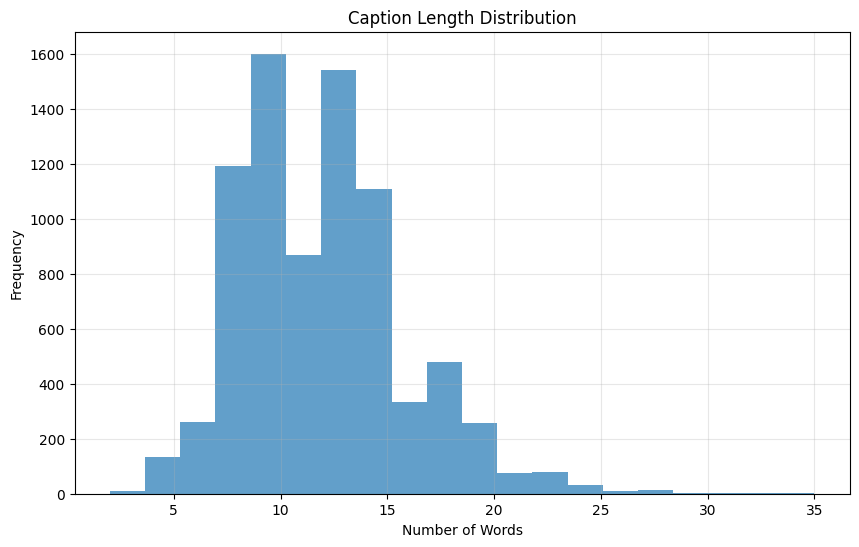

In [64]:
# Cell 7: Analyze caption text
def analyze_captions(captions_df):
    # Extract all captions
    all_captions = captions_df['caption'].tolist()

    # Tokenize captions
    tokenized_captions = [nltk.tokenize.word_tokenize(caption.lower()) for caption in all_captions]

    # Calculate vocabulary statistics
    all_words = [word for caption in tokenized_captions for word in caption]
    vocabulary = Counter(all_words)

    print(f"Total number of captions: {len(all_captions)}")
    print(f"Total words across all captions: {len(all_words)}")
    print(f"Vocabulary size: {len(vocabulary)}")

    # Get most common words
    print(f"\nMost common words:")
    for word, count in vocabulary.most_common(20):
        print(f"{word}: {count}")

    # Calculate caption length statistics
    caption_lengths = [len(caption) for caption in tokenized_captions]
    avg_length = sum(caption_lengths) / len(caption_lengths)
    max_length = max(caption_lengths)
    min_length = min(caption_lengths)

    print(f"\nCaption length statistics:")
    print(f"Average caption length: {avg_length:.2f} words")
    print(f"Maximum caption length: {max_length} words")
    print(f"Minimum caption length: {min_length} words")

    # Plot caption length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(caption_lengths, bins=20, alpha=0.7)
    plt.title('Caption Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

    return vocabulary, max_length

vocabulary, max_caption_length = analyze_captions(captions_df)

In [65]:
def clean_caption(caption):
    # Convert to lowercase
    caption = caption.lower()
    # Remove special characters and extra spaces
    caption = re.sub(r'[^\w\s]', '', caption)
    caption = re.sub(r'\s+', ' ', caption).strip()
    return caption

def preprocess_captions(captions_dict):
    preprocessed_captions = {}
    for image_name, captions in captions_dict.items():
        preprocessed_captions[image_name] = [clean_caption(caption) for caption in captions]
    return preprocessed_captions

def build_vocabulary(captions_dict, min_word_freq=1):
    word_counts = Counter()

    # Count word frequencies
    for captions in captions_dict.values():
        for caption in captions:
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            word_counts.update(tokens)

    # Filter words by frequency
    words = [word for word, count in word_counts.items() if count >= min_word_freq]

    # Create word-to-index and index-to-word mappings
    word_to_idx = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}

    # Add the filtered words starting from index 4
    for idx, word in enumerate(words):
        word_to_idx[word] = idx + 4

    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    print(f"Vocabulary size (after filtering words with frequency < {min_word_freq}): {len(word_to_idx)}")

    return word_to_idx, idx_to_word

clean_captions = preprocess_captions(image_captions)
word_to_idx, idx_to_word = build_vocabulary(clean_captions)

Vocabulary size (after filtering words with frequency < 1): 4093


In [66]:
def prepare_data(captions_dict, word_to_idx, max_length=30):
    data = []

    for image_name, captions in captions_dict.items():
        for caption in captions:
            # Tokenize caption
            tokens = nltk.tokenize.word_tokenize(caption.lower())

            # Convert tokens to indices
            caption_indices = []
            caption_indices.append(word_to_idx['<start>'])
            for token in tokens:
                if token in word_to_idx:
                    caption_indices.append(word_to_idx[token])
                else:
                    caption_indices.append(word_to_idx['<unk>'])
            caption_indices.append(word_to_idx['<end>'])

            # Pad or truncate to max_length
            if len(caption_indices) > max_length:
                caption_indices = caption_indices[:max_length]
            else:
                padding = [word_to_idx['<pad>']] * (max_length - len(caption_indices))
                caption_indices.extend(padding)

            data.append((image_name, caption_indices))

    return data

max_length = min(max_caption_length + 2, 50)  # +2 for <start> and <end> tokens
training_data = prepare_data(clean_captions, word_to_idx, max_length)

# Debugging output
sample_img, sample_caption = training_data[0]
decoded_caption = ' '.join([idx_to_word[idx] for idx in sample_caption])

print(f"Total training samples: {len(training_data)}")
print(f"Sample Image: {sample_img}")
print(f"Caption indices: {sample_caption}")
print(f"Decoded caption: {decoded_caption}")

Total training samples: 8000
Sample Image: 1000268201_693b08cb0e.jpg
Caption indices: [1, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 16, 17, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded caption: <start> a child in a pink dress is climbing up a set of stairs in an entry way <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [67]:
def split_data(data, train_ratio=0.8, val_ratio=0.2):
    np.random.shuffle(data)  # Shuffle the data
    split_idx = int(len(data) * train_ratio)  # Compute training split index

    train_data = data[:split_idx]
    val_size = int(len(train_data) * val_ratio)
    val_data = train_data[-val_size:]

    return train_data, val_data

train_data, val_data = split_data(training_data)
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 6400
Validation set size: 1280


In [68]:
# Cell 14: Define the dataset and dataloader classes
class Flickr8kDataset(Dataset):
    def __init__(self, data, images_path, transform=None):
        self.data = data
        self.images_path = images_path
        self.transform = transform

        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, caption = self.data[idx]
        image_path = os.path.join(self.images_path, image_name)

        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # Convert caption to tensor
        caption = torch.tensor(caption, dtype=torch.long)

        return image, caption

# Cell 15: Create train and validation datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

train_dataset = Flickr8kDataset(train_data, IMAGES_PATH, transform)
val_dataset = Flickr8kDataset(val_data, IMAGES_PATH)

# Cell 16: Create train and validation dataloaders
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 50
Number of validation batches: 10


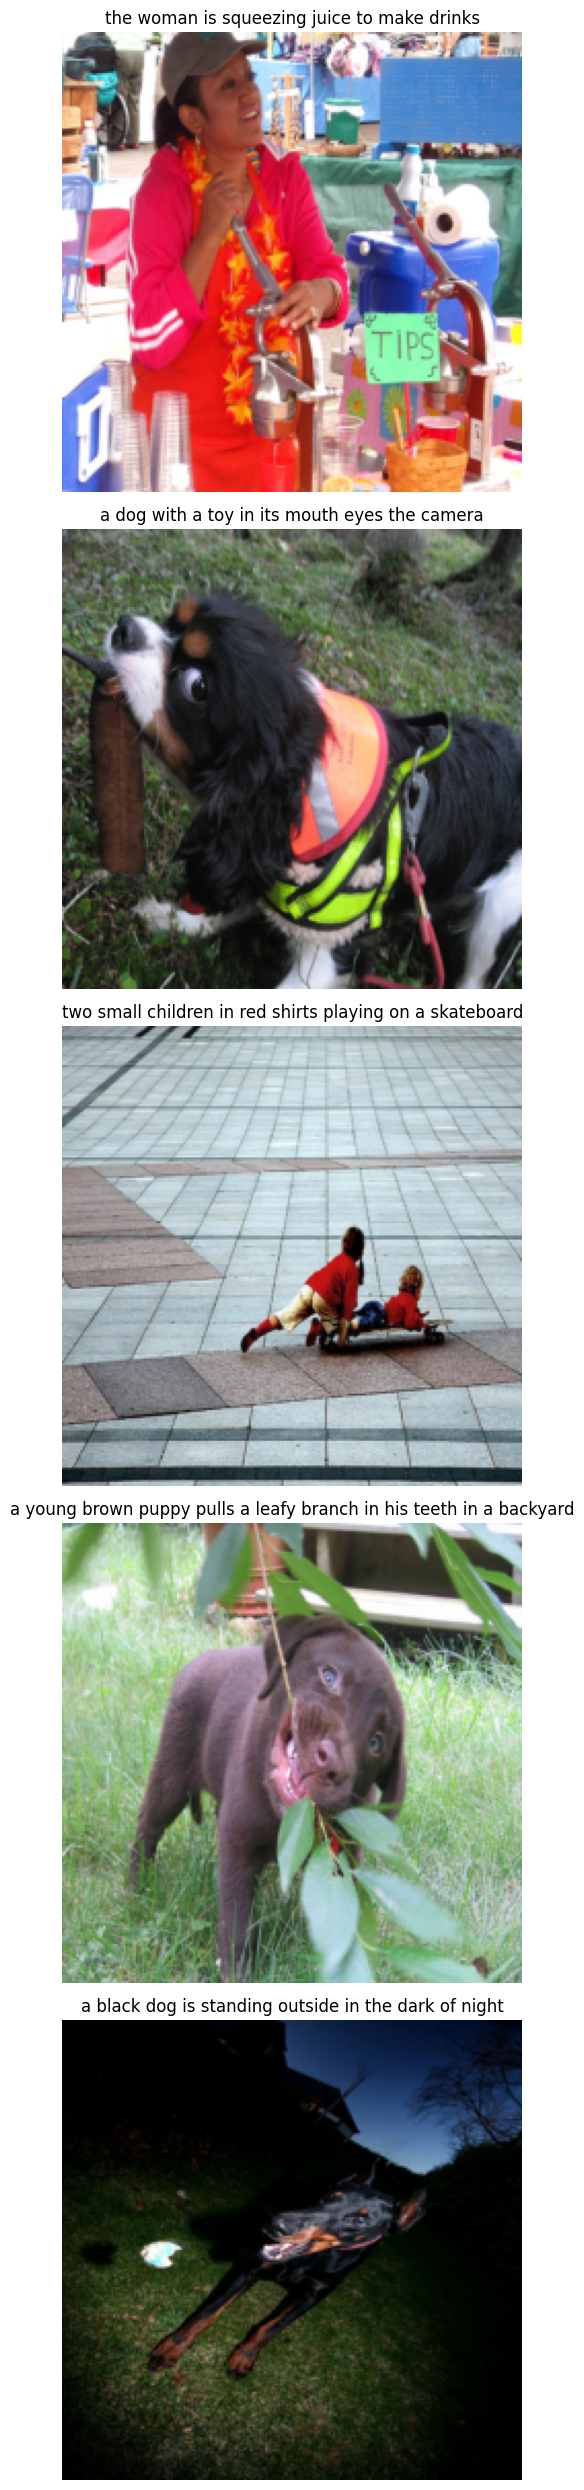

In [69]:
def show_batch(dataloader, idx_to_word):
    for images, captions in dataloader:
        plt.figure(figsize=(15, 25))
        batch_size = images.size(0)

        for i in range(min(5, batch_size)):
            # Convert tensor to image
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            # Decode caption
            cap = captions[i].tolist()
            decoded_cap = []
            for idx in cap:
                word = idx_to_word[idx]
                if word == '<end>':
                    break
                if word not in ['<pad>', '<start>']:
                    decoded_cap.append(word)
            decoded_cap = ' '.join(decoded_cap)

            # Show image and caption
            plt.subplot(5, 1, i+1)
            plt.imshow(img)
            plt.title(decoded_cap)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

show_batch(train_loader, idx_to_word)

In [70]:
# ------------------------------
# Define a simple GCN layer
# ------------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # x: (batch, num_nodes, in_features)
        # adj: (num_nodes, num_nodes) -- assumed same for all examples here
        out = torch.matmul(adj, x)  # aggregate neighbor features
        out = self.linear(out)
        return F.relu(out)

# ------------------------------
# Define the Graph Encoder
# ------------------------------
class GraphEncoder(nn.Module):
    def __init__(self, gcn_in_dim=2048, gcn_hidden_dim=512, num_gcn_layers=2):
        super(GraphEncoder, self).__init__()
        # Use a pretrained ResNet50 and remove the last two layers (avgpool & fc)
        resnet = torchvision.models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        # Build a stack of GCN layers
        self.gcn_layers = nn.ModuleList([
            GCNLayer(gcn_in_dim if i == 0 else gcn_hidden_dim, gcn_hidden_dim)
            for i in range(num_gcn_layers)
        ])

    def forward(self, images):
        # images: (batch, 3, 224, 224)
        cnn_features = self.cnn(images)  # shape: (batch, 2048, H, W)
        b, c, h, w = cnn_features.size()
        # Flatten spatial dimensions: (batch, num_nodes, channels)
        features = cnn_features.view(b, c, -1).permute(0, 2, 1)  # (b, N, 2048)

        # For simplicity, use a fully-connected graph:
        num_nodes = features.size(1)
        # Create an adjacency matrix (ones) and normalize it
        adj = torch.ones(num_nodes, num_nodes).to(features.device)
        deg = adj.sum(1)
        deg_inv = deg.pow(-1)
        deg_inv[deg_inv == float('inf')] = 0.
        D_inv = torch.diag(deg_inv)
        adj_norm = torch.matmul(D_inv, adj)  # normalized adjacency

        # Pass through GCN layers
        for gcn in self.gcn_layers:
            features = gcn(features, adj_norm)
        return features  # (batch, num_nodes, gcn_hidden_dim)

# ------------------------------
# Define the Caption Decoder
# ------------------------------
class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(CaptionDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        # features: (batch, num_nodes, feature_dim)
        # For simplicity, we average features over nodes
        features_avg = features.mean(dim=1)  # (batch, feature_dim)
        # Initialize hidden state with projected image features.
        # Here we assume hidden_size equals feature_dim.
        h0 = features_avg.unsqueeze(0)  # (1, batch, hidden_size)
        c0 = torch.zeros_like(h0)
        embeddings = self.embed(captions)  # (batch, seq_len, embed_size)
        outputs, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.fc(outputs)  # (batch, seq_len, vocab_size)
        return outputs

# ------------------------------
# Full Graph Captioning Model
# ------------------------------
class GraphCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(GraphCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, word_to_idx, idx_to_word, max_length=50):
        """Generate caption for a single image tensor (3,224,224)."""
        self.eval()
        with torch.no_grad():
            # Add batch dimension and encode
            features = self.encoder(image.unsqueeze(0))  # (1, num_nodes, feature_dim)
            features_avg = features.mean(dim=1)  # (1, feature_dim)
            h0 = features_avg.unsqueeze(0)  # (1, 1, hidden_size)
            c0 = torch.zeros_like(h0)
            input_word = torch.tensor([word_to_idx['<start>']]).to(image.device)
            caption_words = []
            hidden = (h0, c0)
            for _ in range(max_length):
                embed = self.decoder.embed(input_word).unsqueeze(0)  # (1,1,embed_size)
                output, hidden = self.decoder.lstm(embed, hidden)
                output = self.decoder.fc(output.squeeze(1))  # (1, vocab_size)
                predicted = output.argmax(dim=1)
                if predicted.item() == word_to_idx['<end>']:
                    break
                caption_words.append(idx_to_word[predicted.item()])
                input_word = predicted
            return ' '.join(caption_words)

# ------------------------------
# Training and Validation Routines
# ------------------------------
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, print_every=10):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (images, captions) in enumerate(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            optimizer.zero_grad()

            # Teacher forcing: input captions except the last token, target is caption shifted by one
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

            # Print batch-wise progress
            if (batch_idx + 1) % print_every == 0 or batch_idx == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, captions in val_loader:
                images = images.to(device)
                captions = captions.to(device)
                outputs = model(images, captions[:, :-1])
                loss = criterion(outputs.reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))
                val_running_loss += loss.item() * images.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_graph_captioning_model.pth')

    return train_losses, val_losses

# ------------------------------
# Evaluation: Compute BLEU Score
# ------------------------------
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import torch

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def evaluate_model(model, val_loader, word_to_idx, idx_to_word, device):
    references = []
    hypotheses = []
    model.eval()

    # Use the correct rouge type names expected by the library
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    smooth_fn = SmoothingFunction().method1  # optional: helps with short sentences

    with torch.no_grad():
        for images, captions in val_loader:
            images = images.to(device)
            for i in range(images.size(0)):
                image = images[i]
                pred_caption = model.generate_caption(image, word_to_idx, idx_to_word)
                hypotheses.append(pred_caption.split())

                ref_caption = captions[i].cpu().numpy().tolist()
                ref_words = [idx_to_word[idx] for idx in ref_caption
                             if idx not in [word_to_idx['<pad>'], word_to_idx['<start>'], word_to_idx['<end>']]]
                references.append([ref_words])

                # Compute ROUGE scores
                ref_text = " ".join(ref_words)
                pred_text = " ".join(pred_caption.split())
                rouge_result = scorer.score(ref_text, pred_text)

                for key in rouge_scores.keys():
                    rouge_scores[key].append(rouge_result[key].fmeasure)

    # BLEU score calculations
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

    avg_rouge = {key: sum(rouge_scores[key]) / len(rouge_scores[key]) for key in rouge_scores}

    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")
    print(f"ROUGE scores: {avg_rouge}")

    return {'BLEU-1': bleu1, 'BLEU-2': bleu2, 'BLEU-3': bleu3, 'BLEU-4': bleu4}, avg_rouge


Epoch [1/1000], Batch [1/1], Loss: 5.6214
Epoch [1/1000], Train Loss: 5.6214, Val Loss: 5.4883
Epoch [2/1000], Batch [1/1], Loss: 5.4841
Epoch [2/1000], Train Loss: 5.4841, Val Loss: 5.3285
Epoch [3/1000], Batch [1/1], Loss: 5.3073
Epoch [3/1000], Train Loss: 5.3073, Val Loss: 5.1363
Epoch [4/1000], Batch [1/1], Loss: 5.0874
Epoch [4/1000], Train Loss: 5.0874, Val Loss: 4.9004
Epoch [5/1000], Batch [1/1], Loss: 4.8431
Epoch [5/1000], Train Loss: 4.8431, Val Loss: 4.6260
Epoch [6/1000], Batch [1/1], Loss: 4.5816
Epoch [6/1000], Train Loss: 4.5816, Val Loss: 4.3347
Epoch [7/1000], Batch [1/1], Loss: 4.2906
Epoch [7/1000], Train Loss: 4.2906, Val Loss: 4.2204
Epoch [8/1000], Batch [1/1], Loss: 4.1792
Epoch [8/1000], Train Loss: 4.1792, Val Loss: 4.0846
Epoch [9/1000], Batch [1/1], Loss: 4.0450
Epoch [9/1000], Train Loss: 4.0450, Val Loss: 3.9757
Epoch [10/1000], Batch [1/1], Loss: 3.9351
Epoch [10/1000], Train Loss: 3.9351, Val Loss: 3.8856
Epoch [11/1000], Batch [1/1], Loss: 3.8408
Epoch

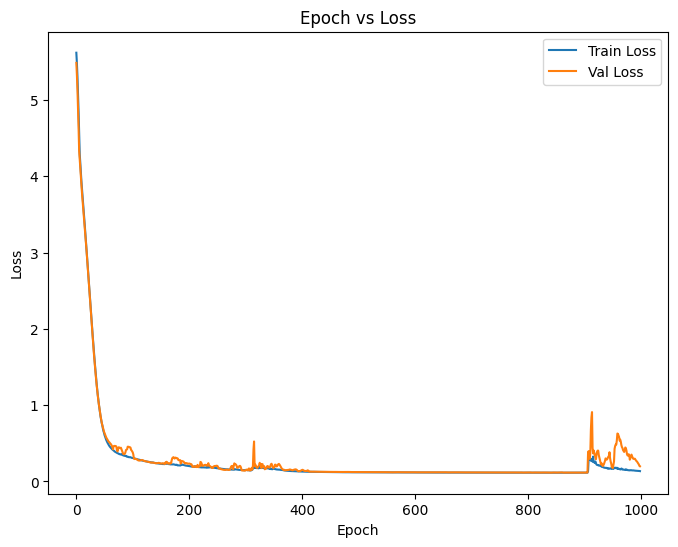

In [33]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (adjust as needed)
embed_size = 256
hidden_size = 512  # here we assume hidden_size equals the GCN output dimension for simplicity
vocab_size = len(word_to_idx)
num_epochs = 1000
learning_rate = 1e-3

# Instantiate encoder, decoder, and full model
encoder = GraphEncoder(gcn_in_dim=2048, gcn_hidden_dim=hidden_size, num_gcn_layers=2)
decoder = CaptionDecoder(embed_size, hidden_size, vocab_size, num_layers=1)
model = GraphCaptioningModel(encoder, decoder).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

In [34]:
# Load the best saved model for evaluation
model.load_state_dict(torch.load('best_graph_captioning_model.pth', map_location=device))

# Evaluate the model using BLEU-1 to BLEU-4 and ROUGE scores
bleu_scores, rouge_scores = evaluate_model(model, train_loader, word_to_idx, idx_to_word, device)

# Print BLEU scores
print("\nEvaluation Metrics:")
for key, value in bleu_scores.items():
    print(f"{key}: {value:.4f}")

# Print ROUGE scores
for key, value in rouge_scores.items():
    print(f"{key.upper()}: {value:.4f}")


BLEU-1: 0.5600
BLEU-2: 0.4561
BLEU-3: 0.4038
BLEU-4: 0.3630
ROUGE scores: {'rouge1': 0.5934752542896915, 'rouge2': 0.3894887147406794, 'rougeL': 0.5676956563773105}

Evaluation Metrics:
BLEU-1: 0.5600
BLEU-2: 0.4561
BLEU-3: 0.4038
BLEU-4: 0.3630
ROUGE1: 0.5935
ROUGE2: 0.3895
ROUGEL: 0.5677


In [35]:
def caption_image(image_path, model, word_to_idx, idx_to_word, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.to(device)
    caption = model.generate_caption(image, word_to_idx, idx_to_word)
    return caption


inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [36]:
captions_df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

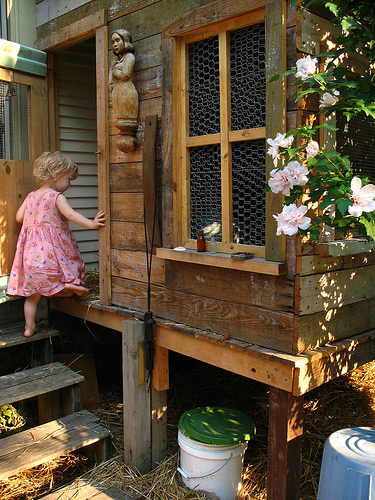

In [37]:
img_path = os.path.join('/content/Images',captions_df['image'].values[0])
Image.open(img_path)

In [38]:
img_path = os.path.join('/content/Images',captions_df['image'].values[0])
generated_caption = caption_image(img_path, model, word_to_idx, idx_to_word, inference_transform, device)
print("Generated Caption:", generated_caption)

Generated Caption: a little girl climbing the stairs to her playhouse
